## Now as we know optimal threshold we can try once again optimalizing stacking model

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
import joblib
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

X_train = pd.read_csv("../../datasets/merged/X_train_imputed_scaled.csv", index_col=0)
X_test = pd.read_csv("../../datasets/merged/X_test_imputed_scaled.csv",  index_col=0)
y_train = pd.read_csv("../../datasets/merged/y_train.csv", index_col=0)["label"]
y_test = pd.read_csv("../../datasets/merged/y_test.csv",  index_col=0)["label"]
groups = pd.read_csv("../../datasets/merged/groups.csv", index_col=0)["star_key"]

rf = joblib.load("../../saved-models/merged/optimal_rf.pkl")
svc = joblib.load("../../saved-models/merged/optimal_svc.pkl")

# === Stacking ===
stack = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('svc', svc)
    ],
    final_estimator=LogisticRegression(),
    stack_method='predict_proba',  # użyj soft predictions
    cv=5
)

stack.fit(X_train, y_train)

# === Predykcje i custom threshold ===
threshold = 0.35
y_proba = stack.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_proba >= threshold).astype(int)

# === Metryki ===
cm = confusion_matrix(y_test, y_pred_thresh)
prec = precision_score(y_test, y_pred_thresh)
rec = recall_score(y_test, y_pred_thresh)
f1 = f1_score(y_test, y_pred_thresh)

print("Confusion Matrix:\n", cm)
print(f"Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")

joblib.dump(stack, "../../saved-models/merged/optimal_stack.pkl")

Confusion Matrix:
 [[ 981  268]
 [ 194 1205]]
Precision: 0.818, Recall: 0.861, F1: 0.839


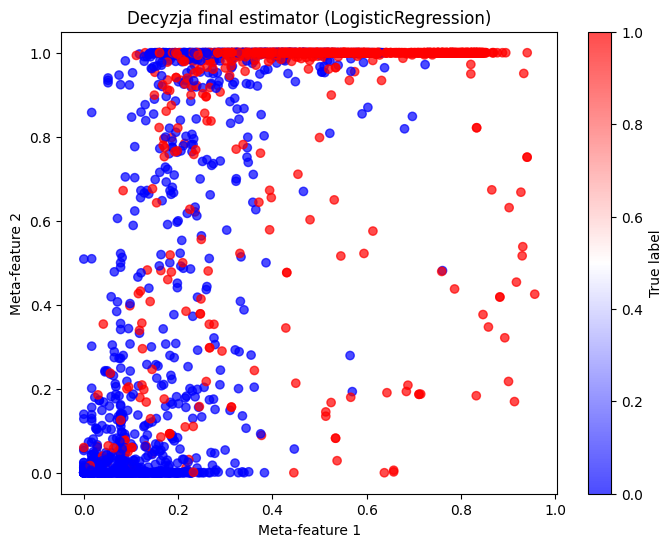

In [41]:
X_meta = stack.transform(X_test)  # to jest wejście do final estimator
y_meta_proba = stack.final_estimator_.predict_proba(X_meta)[:, 1]

from matplotlib import pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(X_meta[:,0], X_meta[:,1], c=y_test, cmap='bwr', alpha=0.7)
plt.xlabel("Meta-feature 1")
plt.ylabel("Meta-feature 2")
plt.title("Decyzja final estimator (LogisticRegression)")
plt.colorbar(label='True label')
plt.show()


I cant see any improvement on decreasing the threshold

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_stack_3d(stack, X_meta, y_true):
    # X_meta musi mieć dokładnie 3 kolumny (np. predict_proba z 3 modeli)
    assert X_meta.shape[1] == 3, "X_meta musi mieć dokładnie 3 kolumny!"

    # Tworzymy siatkę punktów w 3D
    x_min, x_max = X_meta[:,0].min(), X_meta[:,0].max()
    y_min, y_max = X_meta[:,1].min(), X_meta[:,1].max()
    z_min, z_max = X_meta[:,2].min(), X_meta[:,2].max()

    xx, yy, zz = np.meshgrid(
        np.linspace(x_min, x_max, 30),
        np.linspace(y_min, y_max, 30),
        np.linspace(z_min, z_max, 30)
    )

    # Flattenujemy i tworzymy macierz do predict_proba
    grid = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
    probs = stack.predict_proba(grid)[:, 1]
    probs = probs.reshape(xx.shape)

    # Rysowanie 3D
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_meta[:,0], X_meta[:,1], X_meta[:,2], c=y_true, cmap='coolwarm', s=50)
    ax.set_xlabel('Meta-feature 1')
    ax.set_ylabel('Meta-feature 2')
    ax.set_zlabel('Meta-feature 3')

    # Dodajemy powierzchnię prawdopodobieństwa klasy 1
    ax.contourf(xx, yy, zz, probs, levels=[0,0.5,1], alpha=0.3, cmap='coolwarm')
    plt.show()

# Przykład dla stacka z 3 podmodelami
meta_features = np.column_stack([
    stack.named_estimators_['rf'].predict_proba(X_test)[:, 1],
    stack.named_estimators_['svc'].predict_proba(X_test)[:, 1],
    stack.named_estimators_['other_model'].predict_proba(X_test)[:, 1]
])


plot_stack_3d(stack, meta_features, y_test)


KeyError: 'other_model'